In [19]:
Copyright (c) [2018] [Prabhash Kumar Jha and Isheeta Jha] 


using Images
using PyPlot

include("Common.jl")


#---------------------------------------------------------
# Loads grayscale and color image given PNG filename.
#
# INPUTS:
#   filename     given PNG image file
#
# OUTPUTS:
#   gray         single precision grayscale image
#   rgb          single precision color image
#
#---------------------------------------------------------
function loadimage(filename)
rgb = imread(filename)
gray = Common.rgb2gray(rgb)
  return gray::Array{Float64,2}, rgb::Array{Float32,3}
end


#---------------------------------------------------------
# Computes structure tensor.
#
# INPUTS:
#   img             grayscale color image
#   sigma           std for presmoothing derivatives
#   sigma_tilde     std for presmoothing coefficients
#   fsize           filter size to use for presmoothing
#
# OUTPUTS:
#   S_xx       first diagonal coefficient of structure tensor
#   S_yy       second diagonal coefficient of structure tensor
#   S_xy       off diagonal coefficient of structure tensor
#
#---------------------------------------------------------
function computetensor(img::Array{Float64,2},sigma::Float64,sigma_tilde::Float64,fsize::Int)

xder = [ -0.5 0 0.5 ]
yder = [0 -0.5 0 ; 0 0 0; 0 0.5 0]
size= [fsize fsize]
g = Common.gauss2d(sigma, size) #calculate the gaussian filter for smoothening of image
g_tilde = Common.gauss2d(sigma_tilde, size) #calculate the gaussian filter for smoothening of image
Smooth_img = imfilter(img, centered(g), [border="replicate"]) #apply smoothening to the image

Img_x = imfilter(Smooth_img,centered(xder),[border="replicate"]) #apply x derivative

Img_y = imfilter(Smooth_img,centered(yder),[border="replicate"]) #apply y derivative

S_xx = Img_x.^2
S_xx = imfilter(S_xx, centered(g_tilde), [border="replicate"])

S_yy = Img_y.^2
S_yy = imfilter(S_yy, centered(g_tilde), [border="replicate"])

S_xy = Img_x.*Img_y
S_xy = imfilter(S_xy, centered(g_tilde), [border="replicate"])   
  return S_xx::Array{Float64,2},S_yy::Array{Float64,2},S_xy::Array{Float64,2}
end
  


#---------------------------------------------------------
# Computes Harris function values.
#
# INPUTS:
#   S_xx       first diagonal coefficient of structure tensor
#   S_yy       second diagonal coefficient of structure tensor
#   S_xy       off diagonal coefficient of structure tensor
#   sigma      std that was used for presmoothing derivatives
#   alpha      weighting factor for trace
#
# OUTPUTS:
#   harris     Harris function score
#
#---------------------------------------------------------
function computeharris(S_xx::Array{Float64,2},S_yy::Array{Float64,2},S_xy::Array{Float64,2}, sigma::Float64, alpha::Float64)

det = S_xx.*S_yy - S_xy.^2
trace = (S_xx.+ S_yy).^2
harris = sigma^4 *(det - alpha*trace)
  return harris::Array{Float64,2}
end


#---------------------------------------------------------
# Non-maximum suppression of Harris function values.
#   Extracts local maxima within a 5x5 stencils.
#   Allows multiple points with equal values within the same window.
#   Applies thresholding with the given threshold.
#
# INPUTS:
#   harris     Harris function score
#   thresh     param for thresholding Harris function
#
# OUTPUTS:
#   px        x-position of kept Harris interest points
#   py        y-position of kept Harris interest points
#
#---------------------------------------------------------
function nonmaxsupp(harris::Array{Float64,2}, thresh::Float64)
harris_filtered = Common.nlfilter(harris, maximum, 5, 5, "replicate") #find maxima for 5x5 window for each pixel(centred)
harris_filtered = harris.*(harris.>=harris_filtered) #if harris value is equal to local maxima then keep it
harris_filtered[[1 2 end-1 end],:] = 0  # to avoid the image edges
harris_filtered[:, [1 2 end-1 end]] = 0
mask_new = harris_filtered.> thresh
py,px = findn(mask_new)

  return px::Array{Int,1},py::Array{Int,1}
end







nonmaxsupp (generic function with 1 method)

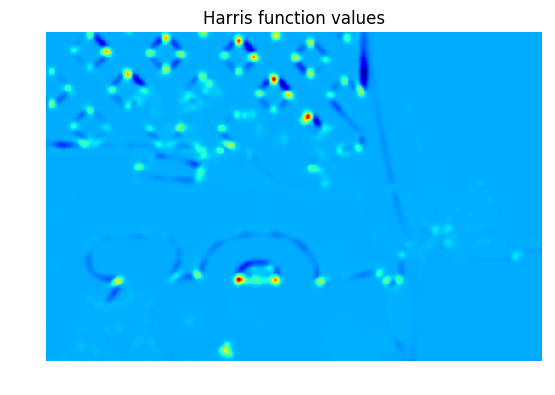

PyObject <matplotlib.text.Text object at 0x0000000036E26198>

In [20]:

#---------------------------------------------------------
#  Harris Detector
#---------------------------------------------------------

  # parameters
  sigma = 2.4               # std for presmoothing derivatives
  sigma_tilde = 1.6*sigma   # std for presmoothing coefficients
  fsize = 25                # filter size for presmoothing
  alpha = 0.06              # Harris alpha
  threshold = 1e-7          # Harris function threshold

  # Load both colored and grayscale image from PNG file
  gray,rgb = loadimage("a3p1.png")
  # Convert to double precision
  gray = Float64.(gray)
  rgb = Float64.(rgb)

  # Compute the three coefficients of the structure tensor
  S_xx,S_yy,S_xy = computetensor(gray,sigma,sigma_tilde,fsize)

  # Compute Harris function value
  harris = computeharris(S_xx,S_yy,S_xy,sigma,alpha)

  # Display Harris images
  figure()
  imshow(harris,"jet",interpolation="none")
  axis("off")
  title("Harris function values")

 


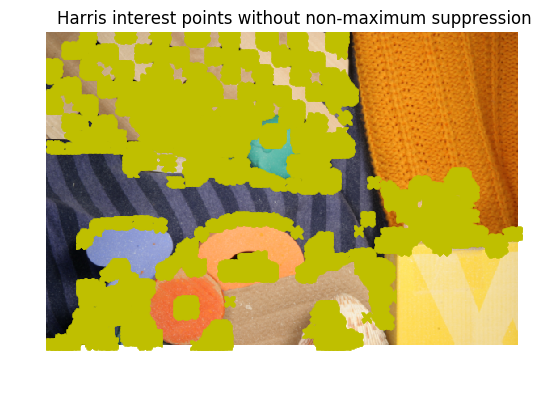

PyObject <matplotlib.text.Text object at 0x00000000378D7F28>

In [21]:
 # Threshold Harris function values
  mask = harris .> threshold
  y,x = findn(mask)
  figure()
  imshow(rgb)
  plot(x,y,"xy")
  axis("off")
  title("Harris interest points without non-maximum suppression")

 

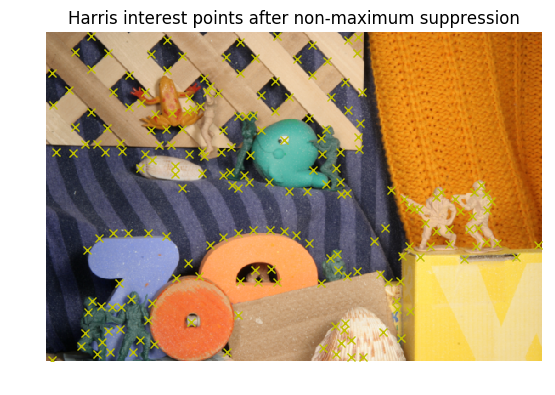

PyObject <matplotlib.text.Text object at 0x000000003C9600F0>

In [22]:
 # Apply non-maximum suppression
  x,y = nonmaxsupp(harris,threshold)

  # Display interest points on top of color image
  figure()
  imshow(rgb)
  plot(x,y,"xy",linewidth=8) 
  axis("off")
  title("Harris interest points after non-maximum suppression")